### Ticker Technical Analysis 
Uses ticker pricing data for given date range and uses common technical analysis studies to calculate the buy and sell signals. 

In [17]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
from datetime import datetime, timedelta

In [18]:
# get tomorrows date so we can use this in the yf.download as an end date

date = datetime.now() + timedelta(days=1)
fmt_date = date.strftime('%Y-%m-%d')
fmt_date

'2024-10-14'

In [19]:
# enter ticker symbol and date range to retrieve

ticker = 'ai'
start_date = '2024-01-25'
end_date =  fmt_date

In [20]:
# Fetch data for a ticker via yahoo api 

df_intra = yf.download(ticker, start_date, end_date, interval='60m', progress=False)
df = yf.download(ticker, start_date, end_date, progress=False)

In [21]:
# EMA - Calculates the Daily EMA, Intra-Day EMA & stores it to respective dataframes

def calculate_ema(fast_ema, slow_ema, data_set):
    fema = data_set['Close'].ewm(span=fast_ema, adjust=False).mean()
    sema = data_set['Close'].ewm(span=slow_ema, adjust=False).mean()
    return fema, sema

# call calculate_ema and pass in the ema values and data sets
df['EMA_A'], df['EMA_B'] = calculate_ema(5, 7, df)
df_intra['EMA_A'], df_intra['EMA_B'] = calculate_ema(5, 7, df_intra)


In [22]:
# RSI - Calulates the RSI and adds median_rsi and RSI to respective dataframes

def calculate_rsi(dataset, overbought_level, oversold_level):
    delta = dataset['Close'].diff(1)

    # Calculate the exponentially weighted moving averages of gains and losses
    gain_ewm = delta.where(delta > 0, 0).ewm(span=14, adjust=False).mean()
    loss_ewm = -delta.where(delta < 0, 0).ewm(span=14, adjust=False).mean()

    # Calculate the relative strength (RS)
    rs = gain_ewm / loss_ewm

    # Calculate the RSI
    rsi = 100 - (100 / (1 + rs))

    # Compute the median between overbought and oversold levels
    median_rsi = np.median([overbought_level, oversold_level])

    dataset['Median_RSI'] = np.where(rsi > median_rsi, 'above_median', 'below_median')

    dataset['rsi'] = rsi

    return rs, rsi, median_rsi


my_rsi_values = calculate_rsi(df, 10, 90)
my_irsi_values = calculate_rsi(df_intra, 10, 90)

In [23]:
df_intra.tail(5)

,Open,High,Low,Close,Adj Close,Volume,EMA_A,EMA_B,Median_RSI,rsi
Datetime,,,,,,,,,,
2024-10-11 11:30:00,26.709999,27.025000,26.660000,26.900000,26.900000,925081,26.498975,26.362664,above_median,81.135671
2024-10-11 12:30:00,26.910000,27.020000,26.740000,26.980000,26.980000,422836,26.659316,26.516998,above_median,82.118188
2024-10-11 13:30:00,26.980000,27.339899,26.950001,27.260000,27.260000,1020738,26.859544,26.702748,above_median,85.225761
2024-10-11 14:30:00,27.260000,27.475000,27.209999,27.334999,27.334999,760272,27.018029,26.860811,above_median,85.978834
2024-10-11 15:30:00,27.340000,27.469999,27.240000,27.240000,27.240000,892069,27.092019,26.955608,above_median,80.017661


In [24]:
# Calculate MACD and signal line
def calculate_macd(df):
    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span=9, adjust=False).mean()
    return macd, signal

df['MACD'], df['Signal'] = calculate_macd(df)
df_intra['MACD'], df_intra['Signal'] = calculate_macd(df_intra)

In [25]:
# # debug code

# closing_prices = df[['Close', 'MACD', 'Signal']]
# closing_prices.tail(60)

In [26]:
# Calculate Signal

def signal(data_set):
    rsi_check = data_set['Median_RSI'] == 'above_median'
    crossed_above_with_rsi = (data_set['EMA_A'] > data_set['EMA_B']) & (data_set['EMA_A'].shift(1) < data_set['EMA_B'].shift(1)) & (rsi_check)
    crossed_above = (data_set['EMA_A'] > data_set['EMA_B']) & (data_set['EMA_A'].shift(1) < data_set['EMA_B'].shift(1)) 
    crossed_above_macd = (data_set['MACD'] > data_set['Signal']) & (data_set['MACD'].shift(1) <= data_set['Signal'].shift(1))
    return crossed_above_with_rsi, crossed_above, crossed_above_macd

# Capture the output of the signal function
crossed_above_with_rsi, crossed_above, crossed_above_macd = signal(df)
icrossed_above_with_rsi, icrossed_above, icrossed_above_macd = signal(df_intra)

### Result of the Signal function: 
will be added to dataframe & also the condition for crossed down.

In [27]:
def algo_result(dataset, indctr1, indctr2, indctr3):
    # DAILY - This uses the result of the choice of indctrs.  
    dataset.loc[indctr1, 'Cross_Direction'] = 'crossed up'

    # Identify when the A-day EMA crosses below the B-Day EMA
    crossed_below = (dataset['EMA_A'] < dataset['EMA_B']) & (dataset['EMA_A'].shift(1) > dataset['EMA_B'].shift(1))
    dataset.loc[crossed_below, 'Cross_Direction'] = 'crossed down'

    # Filter for rows where the 5-day EMA crossed either above or below the 21-day EMA
    condition_met = dataset[dataset['Cross_Direction'].notna()]

    return condition_met

In [28]:
# INTER DAY - pass in the arguments for condition_met
condition_met = algo_result(df, crossed_above_with_rsi, crossed_above, crossed_above_macd)

# Display the dates when the conditions were met and the direction of the crossover
print("\nDates when the conditions were met and cross direction:")
condition_met[['Close', 'EMA_A', 'EMA_B', 'Cross_Direction', 'Median_RSI', 'rsi']]


Dates when the conditions were met and cross direction:


,Close,EMA_A,EMA_B,Cross_Direction,Median_RSI,rsi
Date,,,,,,
2024-01-29,26.059999,25.460000,25.388750,crossed up,above_median,94.758101
2024-01-31,24.780001,25.248889,25.263047,crossed down,below_median,36.125228
2024-02-06,26.010000,25.188300,25.168269,crossed up,above_median,62.287842
2024-02-21,26.180000,27.625547,27.754621,crossed down,below_median,41.332352
2024-02-27,30.100000,28.416651,28.211462,crossed up,above_median,65.060548
2024-03-11,30.870001,31.697122,31.737464,crossed down,below_median,48.691447
2024-05-23,23.940001,25.130969,25.250482,crossed down,below_median,35.655221
2024-05-30,28.570000,25.747722,25.541442,crossed up,above_median,76.084876
2024-06-17,29.209999,29.867383,29.898684,crossed down,below_median,49.254385


In [29]:
# INTRA DAY - pass in the arguments for condition_met
icondition_met = algo_result(df_intra, icrossed_above_with_rsi, icrossed_above, icrossed_above_macd)

# Display the dates when the conditions were met and the direction of the crossover
print("\nDates when the conditions were met and cross direction:")
icondition_met[['Close', 'EMA_A', 'EMA_B', 'Cross_Direction', 'Median_RSI', 'rsi']]


Dates when the conditions were met and cross direction:


,Close,EMA_A,EMA_B,Cross_Direction,Median_RSI,rsi
Datetime,,,,,,
2024-01-25 11:30:00,25.340000,25.528445,25.540063,crossed down,below_median,28.761734
2024-01-29 09:30:00,25.570000,25.278636,25.262041,crossed up,above_median,67.651652
2024-01-30 11:30:00,25.570000,25.646863,25.651805,crossed down,below_median,48.617352
2024-02-01 15:30:00,24.940001,24.825024,24.824362,crossed up,above_median,50.199987
2024-02-02 10:30:00,24.639999,24.775566,24.788703,crossed down,below_median,39.447101
...,...,...,...,...,...,...
2024-09-27 14:30:00,24.125000,24.231662,24.242746,crossed down,below_median,46.328262
2024-09-30 10:30:00,24.330000,24.270162,24.265255,crossed up,above_median,58.654057
2024-09-30 12:30:00,24.190001,24.250517,24.253331,crossed down,below_median,47.420010


### Plot 'crossed up' and 'crossed down' signals on line graph, and calculate total return


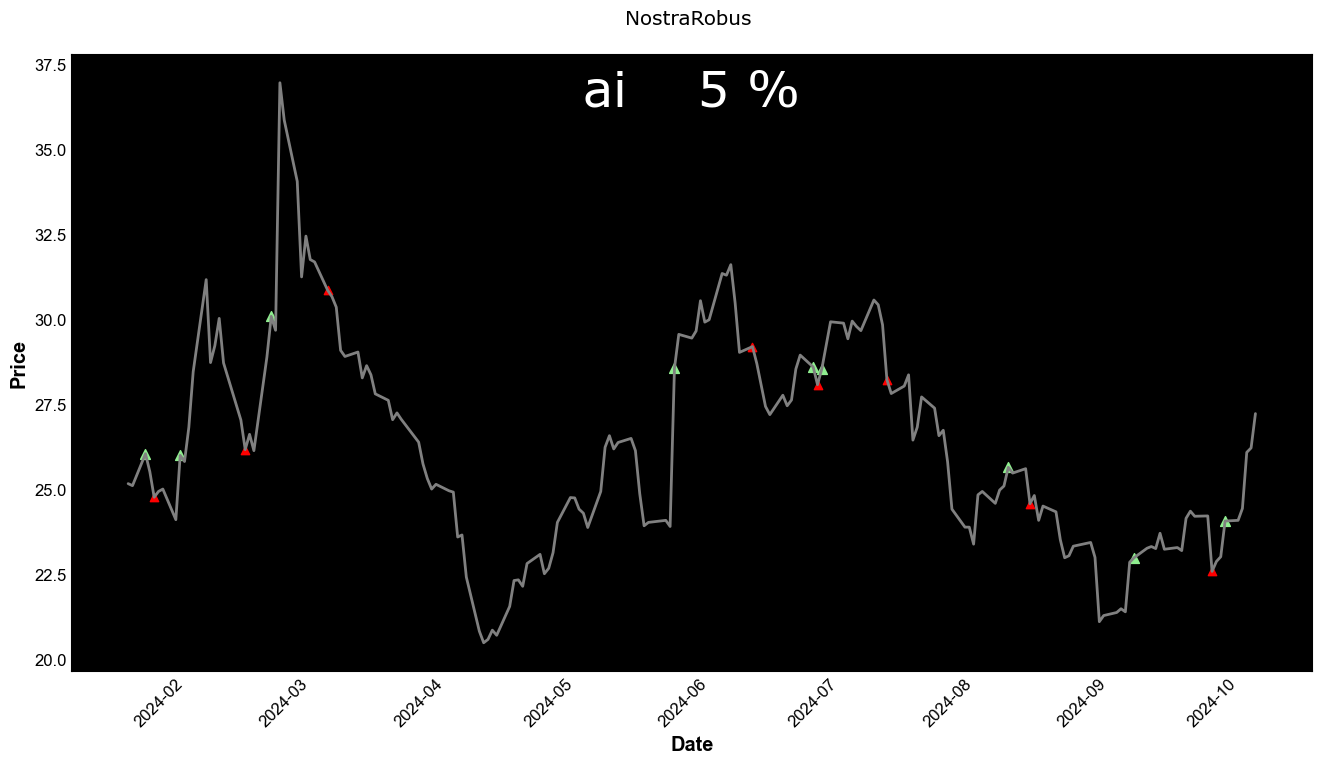

Results For Ticker:   ai
Initial Investment:  26.059999465942383
Final Portfolio Value:  27
Profit/Loss:  1.2
Percent: 4.6%




,Action,Date,Open,Close,Price,Cash
0,Buy,2024-01-29,25.120001,26.059999,26.059999,0.000000
1,Sell,2024-01-31,25.320000,24.780001,25.320000,24.780001
2,Buy,2024-02-06,24.799999,26.010000,26.010000,-1.230000
3,Sell,2024-02-21,26.250000,26.180000,26.250000,24.950001
4,Buy,2024-02-27,29.334999,30.100000,30.100000,-5.150000
5,Sell,2024-03-11,31.500000,30.870001,31.500000,25.720001
6,Buy,2024-05-30,26.459999,28.570000,28.570000,-2.849998
7,Sell,2024-06-17,28.680000,29.209999,28.680000,26.360001
8,Buy,2024-07-01,28.690001,28.610001,28.610001,-2.250000
9,Sell,2024-07-02,28.650000,28.090000,28.650000,25.840000


In [30]:
# Initialize variables
init_cost = 1 # we need this set so when conditions are not met, we don't divide by 0
cash = init_cost  # Initial cash balance
shares_owned = 0
portfolio_value = cash
prev_crossed_above = False
rsi_above_median = False
transactions = []
last_trans = '' # not being used
df.iloc[-1, df.columns.get_loc('Cross_Direction')] = last_trans # not being used

# Plot the line graph with arrows indicating the direction of crossover
plt.figure(figsize=(16, 8))
plt.plot(df.index, df['Close'], label='Close Price', color='gray')
plt.gca().set_facecolor('black')  # Set the background color to black
plt.xticks(rotation=45)




# Find the first crossed up event and set the initial cost
for index, row in df.iterrows():
    if row['Cross_Direction'] == 'crossed up':
        init_cost = row['Close']  # Set init_cost to the price at the first crossed up event
        cash = init_cost  # Set cash to the initial cost
        break

# Loop through the dataframe
for index, row in df.iterrows():
    if row['Cross_Direction'] == 'crossed up' and prev_crossed_above == False:  # Check if the Cross_Direction column is 'crossed up'
        # Buy one share
        # shares_owned += 1
        cash -= row['Close']  # Deduct purchase price from cash
        transactions.append(('Buy', index, row['Open'], row['Close'], row['Close'], cash))
        prev_crossed_above = True
        plt.scatter(index, row['Close'], marker='^', color='lightgreen', s=50, label='Crossed Up')
    elif row['Cross_Direction'] == 'crossed down' and prev_crossed_above:  # Check if the Cross_Direction column is 'crossed down':
        cash += row['Close'] #* shares_owned  # Add sale price to cash
        transactions.append(('Sell', index, row['Open'], row['Close'], row['Open'], cash))
        prev_crossed_above = False
        plt.scatter(index, row['Close'], marker='^', color='red', label='Crossed Down')
    else:
        pass
    
# Calculate final portfolio value
last_close_price = df['Close'].iloc[-1] #get last close price in order to calc our return
portfolio_value =  last_close_price - cash  #portfolio value is our initial purchase price minus last close price.
initial_investment = init_cost # Initial cash investment
profit_loss = portfolio_value - initial_investment # net difference of our investment and final close price
percent = (profit_loss / initial_investment) * 100 # profit_loss as percent of investment

# Add the ticker symbol and other things as labels
plt.text(0.5, 0.9, ticker + '    ' + str(round(percent)) + ' %', transform=plt.gca().transAxes, fontsize=36, verticalalignment='bottom', \
         horizontalalignment='center', fontname='MS Reference Sans Serif', fontweight='bold', color='white')
plt.title('NostraRobus \n', fontname='MS Reference Sans Serif', fontweight='bold', color='black')
plt.xlabel('Date', color='black')
plt.ylabel('Price', color='black')
plt.tick_params(axis='x', colors='black')
plt.tick_params(axis='y', colors='black')
plt.grid(False)
plt.show()



print('Results For Ticker:  ', ticker)
print('Initial Investment: ', initial_investment)
print("Final Portfolio Value: ", int(portfolio_value))
print("Profit/Loss: ", round(profit_loss,1))
print("Percent: {:.1f}%".format(percent))
print('\n')
transactions_df = pd.DataFrame(transactions, columns=['Action', 'Date', 'Open', 'Close', 'Price', 'Cash'])
transactions_df



### Same calculation as line graph but with candlestick graph

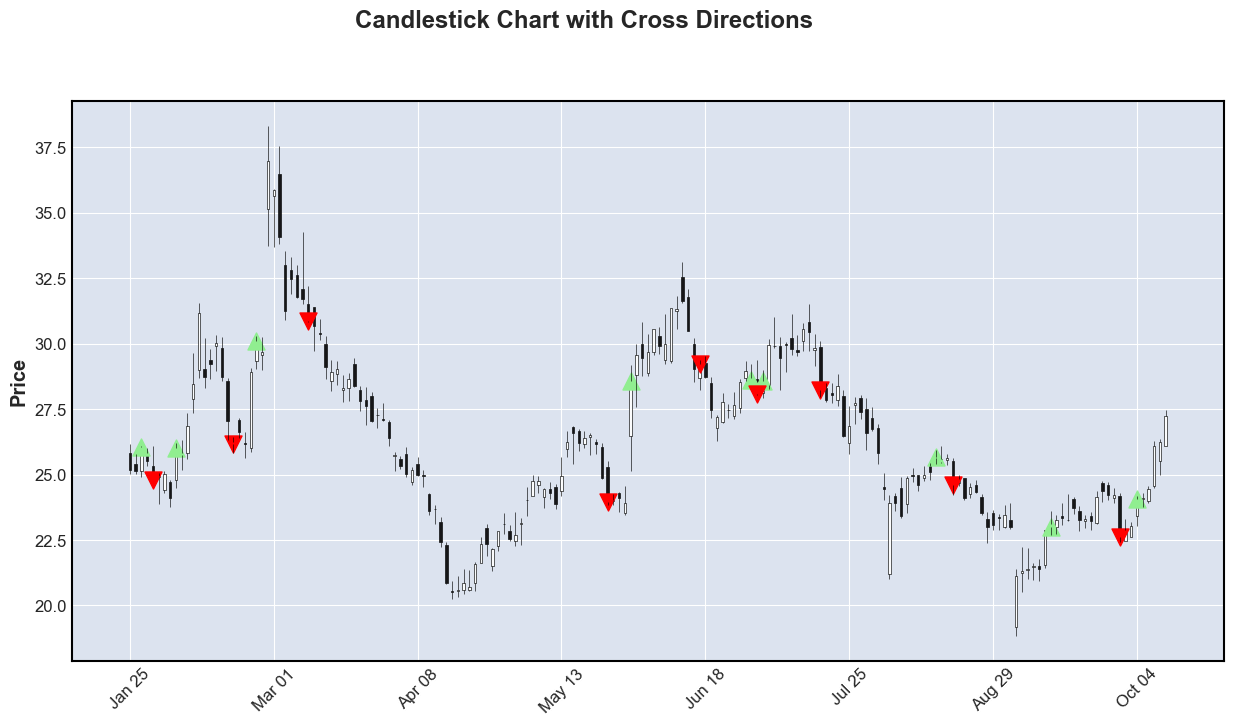

In [31]:
# Plot the candlestick chart with the custom black background
mpf.plot(
    df,
    type='candle',
    title='Candlestick Chart with Cross Directions',
    figsize=(16, 8),
    ylabel='Price',
    addplot=[
        mpf.make_addplot(
            np.where(df['Cross_Direction'] == 'crossed up', df['Close'], np.nan),
            type='scatter',
            markersize=150,  # Marker size
            marker='^',      # Upward triangle for 'crossed up'
            color='lightgreen'  # Color for 'crossed up'
        ),
        mpf.make_addplot(
            np.where(df['Cross_Direction'] == 'crossed down', df['Close'], np.nan),
            type='scatter',
            markersize=150,  # Marker size
            marker='v',      # Downward triangle for 'crossed down'
            color='red'      # Color for 'crossed down'
        )
    ]
)


### Intraday Candlestick Graph

c:\Users\rindel\AppData\Local\Programs\Python\Python311\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


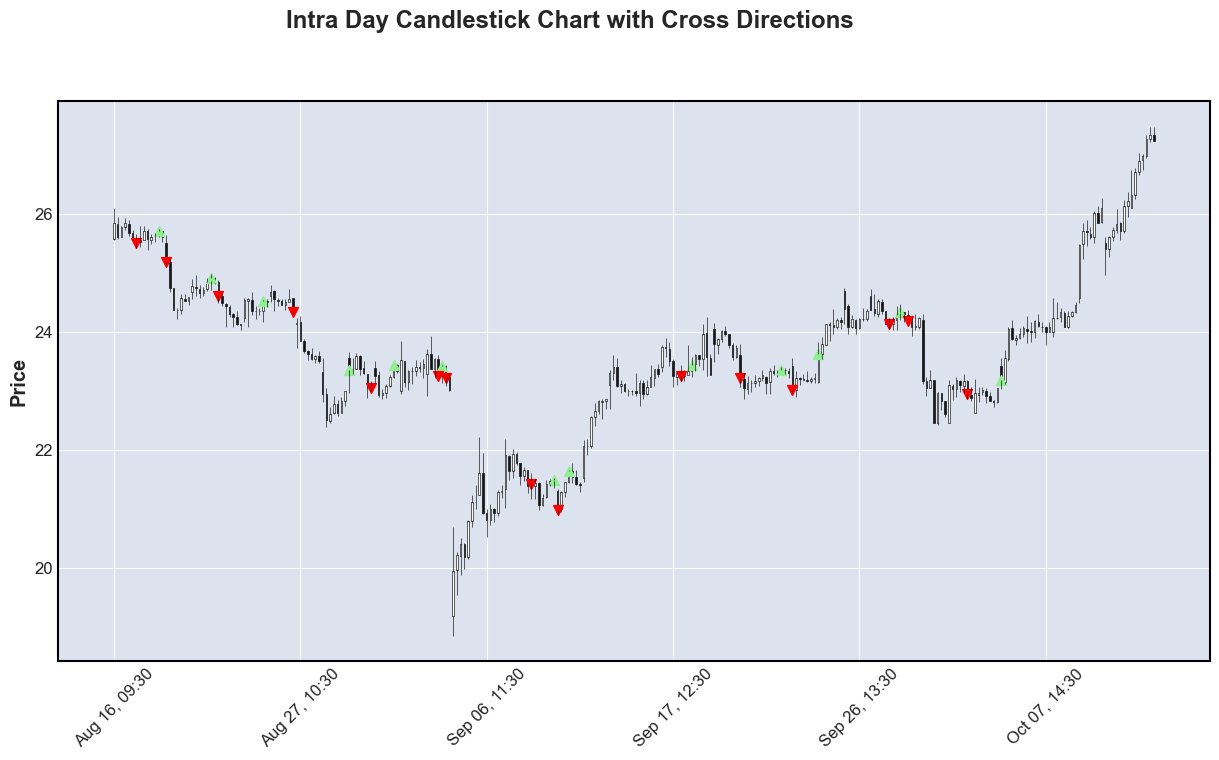

In [33]:
# Use lat 30 days for intraday graph 
start_span = '2024-08-16'
end_span = '2024-10-13'
date_range = df_intra[start_span:end_span]

span = 20
span_days = pd.Timestamp.now() - pd.Timedelta(days=span)
df_intra_span = df_intra[df_intra.index >= span_days]

span = date_range # use date_range or df_intra_span 

# Plot the INTRA DAY candlestick & SIGNAL chart with the custom black background
mpf.plot(
    span,
    type='candle',
    title='Intra Day Candlestick Chart with Cross Directions',
    figsize=(16, 8),
    ylabel='Price',
    warn_too_much_data=len(df_intra_span) + 1,
    addplot=[
        mpf.make_addplot(
            np.where(span['Cross_Direction'] == 'crossed up', span['Close'], np.nan),
            type='scatter',
            marker='^',      # Upward triangle for 'crossed up'
            markersize=50,  # Marker size
            color='lightgreen'  # Color for 'crossed up'
        ),
        mpf.make_addplot(
            np.where(span['Cross_Direction'] == 'crossed down', span['Close'], np.nan),
            type='scatter',
            marker='v',      # Downward triangle for 'crossed down'
            markersize=50,  # Marker size
            color='red'      # Color for 'crossed down'
        )
    ]
)